In [1]:
import pandas as pd

import pickle


import dask.dataframe as dd
df = dd.read_csv("../Dataset1/*").compute()

# df = pd.read_csv("/content/drive/My Drive/Year4Project/*")

X = df.iloc[:,:400]
Y = df.iloc[:,400:]



In [2]:
X.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_391,feature_392,feature_393,feature_394,feature_395,feature_396,feature_397,feature_398,feature_399,feature_400
0,1.779518,1.776715,1.768305,1.754282,1.734640,1.709368,1.678452,1.641877,1.599627,1.551680,...,1.551663,1.599611,1.641864,1.678441,1.709359,1.734632,1.754275,1.768300,1.776713,1.779518
1,5.202017,5.198922,5.189642,5.174175,5.152518,5.124669,5.090624,5.050379,5.003929,4.951272,...,4.951313,5.003966,5.050411,5.090652,5.124692,5.152537,5.174188,5.189651,5.198927,5.202017
2,6.506681,6.504264,6.497006,6.484906,6.467960,6.446162,6.419503,6.387977,6.351573,6.310280,...,6.310234,6.351532,6.387942,6.419473,6.446136,6.467940,6.484892,6.496997,6.504259,6.506681
3,0.280789,0.276659,0.264276,0.243636,0.214729,0.177546,0.132073,0.078299,0.016210,-0.054203,...,-0.054104,0.016297,0.078375,0.132138,0.177600,0.214772,0.243667,0.264297,0.276669,0.280789
4,-0.446154,-0.450173,-0.462235,-0.482346,-0.510517,-0.546761,-0.591093,-0.643533,-0.704101,-0.772815,...,-0.772851,-0.704132,-0.643560,-0.591116,-0.546779,-0.510532,-0.482357,-0.462242,-0.450176,-0.446154


In [3]:
Y.head()

,label_1,label_2,label_3
0,1.336096,1.154233,1.412762
1,1.486461,1.666035,1.321904
2,1.157362,1.442704,1.513383
3,1.899173,1.211458,1.401861
4,1.791140,1.266292,1.239542


In [4]:
import numpy as np


gridpoints = []
for z in np.linspace(-2,2,11):
  for y in np.linspace(-2,2,11):
    for x in np.linspace(-2,2,11):
      gridpoints.append((x,y,z))



In [5]:
def insideEllipsoid(radii, point):
  a = radii[0]
  b = radii[1]
  c = radii[2]

  x = point[0]
  y = point[1]
  z = point[2]

  return (x/a)**2 + (y/b)**2 + (z/c)**2 < 1



In [6]:
Y_dots = []

for j in range(len(Y)):
  if j%100==0:
    print(j)
  Y_dots.append([insideEllipsoid(Y.iloc[j], gridpoint) for gridpoint in gridpoints])


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


In [7]:
y_voxels = pd.DataFrame(Y_dots, columns = gridpoints)

In [8]:
pd.concat([X.reset_index(drop=True), y_voxels],axis=1, ignore_index=True).to_csv('../VoxelsDataset/ellipsoidVoxels.csv', index=False)

START HERE FOR TRAINING

In [1]:
import pandas as pd
import dask.dataframe as dd

df1 = dd.read_csv("../VoxelsDataset/ellipsoidVoxels/*").compute()



In [2]:
df1.head()
df1.tail()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,1721,1722,1723,1724,1725,1726,1727,1728,1729,1730
95,9995,10.731863,10.729460,10.722250,10.710232,10.693406,10.671768,10.645318,10.614052,10.577968,...,False,False,False,False,False,False,False,False,False,False
96,9996,11.263281,11.260546,11.252344,11.238678,11.219551,11.194969,11.164939,11.129471,11.088577,...,False,False,False,False,False,False,False,False,False,False
97,9997,6.166641,6.164243,6.157033,6.145008,6.128163,6.106493,6.079987,6.048637,6.012429,...,False,False,False,False,False,False,False,False,False,False
98,9998,11.340998,11.338141,11.329564,11.315271,11.295267,11.269559,11.238156,11.201072,11.158323,...,False,False,False,False,False,False,False,False,False,False
99,9999,8.826921,8.823427,8.812951,8.795497,8.771070,8.739678,8.701334,8.656053,8.603855,...,False,False,False,False,False,False,False,False,False,False


In [4]:
X = df1.iloc[:,:400]
Y = df1.iloc[:,400:]

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.5, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.5, random_state = 42)

In [13]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
x_train = ss.fit_transform(x_train)
x_val = ss.transform(x_val)
x_test = ss.transform(x_test)


In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import SGD, Adam

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=50, verbose=1,)
early_stop = EarlyStopping(monitor='val_loss', patience=100, verbose=1, restore_best_weights=True)
opt = Adam()

model = Sequential()
model.add(Dense(1000, input_dim=400, kernel_initializer='normal', activation='relu'))
model.add(Dense(1000, kernel_initializer='normal', activation='relu'))
model.add(Dense(2000, kernel_initializer='normal', activation='relu'))
model.add(Dense(2000, kernel_initializer='normal', activation='relu'))
model.add(Dense(2000, kernel_initializer='normal', activation='relu'))
model.add(Dense(2000, kernel_initializer='normal', activation='relu'))
model.add(Dense(1331, kernel_initializer='normal', activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'], )
model.summary()

Using TensorFlow backend.
Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1000)              401000    
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_3 (Dense)              (None, 2000)              2002000   
_________________________________________________________________
dense_4 (Dense)              (None, 2000)              4002000   
_________________________________________________________________
dense_5 (Dense)              (None, 2000)              4002000   
_________________________________________________________________
dense_6 (Dense)              (None, 2000)              4002000   
______________________

In [31]:
history = model.fit(x=x_train, y=y_train, validation_data = (x_val, y_val), epochs=1000, verbose=1, callbacks=[reduce_lr, early_stop])


Train on 2500 samples, validate on 2500 samples
Epoch 1/1000
2500/2500 [==============================] - 25s 10ms/step - loss: 0.0045 - accuracy: 0.9982 - val_loss: 0.0103 - val_accuracy: 0.9959
Epoch 2/1000
2500/2500 [==============================] - 27s 11ms/step - loss: 0.0054 - accuracy: 0.9978 - val_loss: 0.0092 - val_accuracy: 0.9963
Epoch 3/1000
2500/2500 [==============================] - 19s 7ms/step - loss: 0.0040 - accuracy: 0.9984 - val_loss: 0.0085 - val_accuracy: 0.9965
Epoch 4/1000
2500/2500 [==============================] - 18s 7ms/step - loss: 0.0037 - accuracy: 0.9985 - val_loss: 0.0095 - val_accuracy: 0.9963
Epoch 5/1000
2500/2500 [==============================] - 18s 7ms/step - loss: 0.0039 - accuracy: 0.9984 - val_loss: 0.0094 - val_accuracy: 0.9965
Epoch 6/1000
2500/2500 [==============================] - 19s 7ms/step - loss: 0.0041 - accuracy: 0.9983 - val_loss: 0.0086 - val_accuracy: 0.9966
Epoch 7/1000
2500/2500 [==============================] - 18s 7ms/st

In [46]:
from keras.models import load_model

model.evaluate(x_train, y_train), model.evaluate(x_val, y_val), model.evaluate(x_test, y_test)

5000/5000 [==============================] - 5s 921us/step


([0.0026973369464278222, 0.998999834060669],
 [0.008172114140540362, 0.9968057870864868],
 [0.008296324820816516, 0.9967682361602783])

In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np
print(accuracy_score(np.round((model.predict(x_train)*1)).flatten(), np.array(y_train*1).flatten()))
print(precision_score(np.round((model.predict(x_train)*1)).flatten(), np.array(y_train*1).flatten()))
print(recall_score(np.round((model.predict(x_train)*1)).flatten(), np.array(y_train*1).flatten()))

0.9989998497370398
0.9957104838011713
0.9982844581671723


In [48]:
print(accuracy_score(np.round((model.predict(x_val)*1)).flatten(), np.array(y_val*1).flatten()))
print(precision_score(np.round((model.predict(x_val)*1)).flatten(), np.array(y_val*1).flatten()))
print(recall_score(np.round((model.predict(x_val)*1)).flatten(), np.array(y_val*1).flatten()))

0.9968060105184072
0.9879875873563555
0.9925550704468427


In [49]:
print(accuracy_score(np.round((model.predict(x_test)*1)).flatten(), np.array(y_test*1).flatten()))
print(precision_score(np.round((model.predict(x_test)*1)).flatten(), np.array(y_test*1).flatten()))
print(recall_score(np.round((model.predict(x_test)*1)).flatten(), np.array(y_test*1).flatten()))

0.9967682945154019
0.9878078577013292
0.9926938197572428


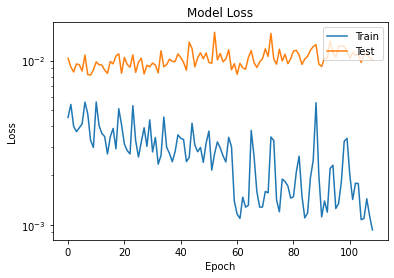

In [50]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation
'], loc='upper right')
plt.savefig('../Models/NNVoxelsLossCurve.png')
plt.show()

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

#Logistic Regression Doesn't Acc
lr = MultiOutputClassifier(LogisticRegression(max_iter=4000), n_jobs=-1)

columns2 = y_train.T.loc[y_train.nunique()==2].index
columns1 = y_train.T.loc[y_train.nunique()==1].index
y_train[columns2]


lr.fit(x_train, y_train[columns2])

MultiOutputClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                   dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1,
                                                   l1_ratio=None, max_iter=4000,
                                                   multi_class='auto',
                                                   n_jobs=None, penalty='l2',
                                                   random_state=None,
                                                   solver='lbfgs', tol=0.0001,
                                                   verbose=0,
                                                   warm_start=False),
                      n_jobs=-1)

In [52]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
y_pred = pd.DataFrame(lr.predict(x_train), columns = columns2)
for i in columns1:
  y_pred[i] = y_train[i].mean()

print(accuracy_score(np.array(y_pred*1).flatten(), np.array(y_train*1).flatten()))
print(precision_score(np.array(y_pred*1).flatten(), np.array(y_train*1).flatten()))
print(recall_score(np.array(y_pred*1).flatten(), np.array(y_train*1).flatten()))

0.7137688955672427
0.14093918587542914
0.14105363452300607


In [53]:
y_pred = pd.DataFrame(lr.predict(x_val), columns = columns2)

for i in columns1:
  y_pred[i] = y_train[i].mean()

print(accuracy_score(np.array(y_pred*1).flatten(), np.array(y_val*1).flatten()))
print(precision_score(np.array(y_pred*1).flatten(), np.array(y_val*1).flatten()))
print(recall_score(np.array(y_pred*1).flatten(), np.array(y_val*1).flatten()))

0.7161989481592788
0.13742360887745256
0.13733024567350188


In [54]:
y_pred = pd.DataFrame(lr.predict(x_test), columns = columns2)

for i in columns1:
  y_pred[i] = y_train[i].mean()

print(accuracy_score(np.array(y_pred*1).flatten(), np.array(y_test*1).flatten()))
print(precision_score(np.array(y_pred*1).flatten(), np.array(y_test*1).flatten()))
print(recall_score(np.array(y_pred*1).flatten(), np.array(y_test*1).flatten()))

0.7143386927122465
0.13940469985231518
0.13952287794804913
